<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Test_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets --quiet

from datasets import load_dataset
from huggingface_hub import login

# First : Create an account on Hugging face, and create also a token

# Connection to hugging face
login(token="")

dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

df = dataset['validation'].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Packages

In [34]:
!pip install wikidata --quiet
!pip install spacy --quiet
!python -m spacy download en_core_web_md

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from wikidata.client import Client

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import requests
import certifi
import json
import spacy
from collections import deque
from functools import lru_cache
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from collections import Counter



from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 30.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Features extractions

Photos

In [3]:
def extract_entity_id(url):

    """
    Function that extract the identity of an item, based on its wikidata link page

    Parameters:
    url (str): A Wikidata URL

    Returns:
    str: The entity ID extracted from the URL

    """
    return url.strip().split("/")[-1]



def get_claims(wikidata_url):

    """
    Return the claims associated with a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata item

    Returns:
    dict: A dictionary of claims as keys, and wikidata item as values.
    """
    # Extract the id of the item
    entity_id = extract_entity_id(wikidata_url)

    # Extract information of the item
    client = Client()
    item = client.get(entity_id, load=True)

    # Extract the claims of the item
    claims = item.data.get("claims", {})

    return claims


def get_sitelinks(wikidata_url):

    """
    Return the sitelinks associated with a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata item.

    Returns:
    dict: A dictionary with languages codes as keys, and sitelink URLs as values.
    """

    # Extract the id of the item
    entity_id = extract_entity_id(wikidata_url)

    # Extract information of the item
    client = Client()
    item = client.get(entity_id, load=True)

    # Extract the claims of the item
    sitelinks = item.data.get("sitelinks", {})

    return sitelinks

def get_en_wikipedia_url(wikidata_url):

    """
    Returns the english wikipedia page associated to a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata item.

    Returns:
    str: A string with an english wikipedia page.
    """

    sitelinks = get_sitelinks(wikidata_url)

    # Find the english wikidepia page
    enwiki = sitelinks.get("enwiki")

    # Return its URL
    return(enwiki.get("url"))


def get_wikipedia_image(wikidata_url):

    """
    Returns the photo in the infobox, in the english wikipedia page associated to a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata item.

    Returns:
    np.ndarray or None: The image from the Wikipedia infobox as a NumPy array, or None if there is an error in the process.
    """
    # Extract the english wikipedia page if it exists
    try:
      wikipedia_url = get_en_wikipedia_url(wikidata_url)

    except Exception:
      return None

    # Fighting against the bots protection
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(wikipedia_url, headers=headers)

    # Make sur the response has no error
    if response.status_code == 200:

        # Extract the infobox of the wikipedia page
        soup = BeautifulSoup(response.text, 'html.parser')
        infobox = soup.find('table', {'class': 'infobox'})

        if infobox:
            # Find the image
            img_tag = infobox.find('img')
            if img_tag:
                # Recreate the URL of the image
                img_url = 'https:' + img_tag['src']
                try:
                    img_response = requests.get(img_url, headers=headers)
                    img = Image.open(BytesIO(img_response.content))
                    return np.array(img)
                except:
                    return None
    # If there is an error somewhere, return None
    return None


def resize_array(image):

    """
    Resizes an image to a the size 128x128.

    Parameters:
    image (np.ndarray or None): The input image.

    Returns:
    np.ndarray or None: The resized image.
    """

    if image is not None:
      image = image.astype(np.uint8)
      img_pil = Image.fromarray(image)
      img_pil = img_pil.convert("RGB")
      img_pil = img_pil.resize((128, 128), Image.Resampling.LANCZOS)

      return np.array(img_pil)

    return None


In [4]:
# Application of the extraction of the photos

df['image'] = df['item'].apply(lambda x: get_wikipedia_image(x))

df['image'] = df['image'].apply(lambda x: json.dumps(x.tolist() if x is not None else None))

df['image'] = df['image'].apply(lambda s: np.array(json.loads(s)) if pd.notnull(s) else None)

df['image'] = df['image'].apply(lambda x: resize_array(x))

Sparql

In [5]:
WIKIDATA_SPARQL_URL = "https://query.wikidata.org/sparql"
HEADERS = {
    "Accept": "application/sparql-results+json",
    "User-Agent": "ExplorateurWikidata/0.1 (truc@truc.com)"
}


#cache avoir requesting the same item several times during the graph search
@lru_cache(maxsize=None)

def get_superclasses(qid):

    """
    Returns the superclasses (P279) of a given Wikidata item.

    Parameters:
    qid (str): The Wikidata entity identifier.

    Returns:
    tuple: A tuple of QIDs representing the superclasses of the Wikidata entity.
    """

    query = f"""
    SELECT ?superclass WHERE {{
      wd:{qid} wdt:P279 ?superclass.
    }}
    """

    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]

    return tuple(r["superclass"]["value"].split("/")[-1] for r in results)


def get_subclass_depth_bfs(url, max_depth=20):

    """
    Return the depth of a Wikidata item in its subclass hierarchy using BFS.

    Parameters:
    url (str): The Wikidata URL of the item
    max_depth (int, optional): The maximum depth to search.

    Returns:
    int or None: The depth of the item in the subclass hierarchy
    """

    qid = extract_entity_id(url)
    visited = set()
    queue = deque([(qid, 1)])

    while queue:
        current_qid, depth = queue.popleft()
        if current_qid in visited:
            continue
        visited.add(current_qid)

        parents = get_superclasses(current_qid)
        if not parents:
            return depth
        if depth >= max_depth:
            return None
        for parent_qid in parents:
            queue.append((parent_qid, depth + 1))

    return None



def get_direct_subclasses(url):

    """
    Returns the number of direct subclasses (P279) of a given Wikidata item.

    Parameters:
    url (str): The Wikidata URL of the item.

    Returns:
    int: The number of direct subclasses of the Wikidata item.
    """
    qid = extract_entity_id(url)
    query = f"""
    SELECT ?subclass WHERE {{
      ?subclass wdt:P279 wd:{qid} .
    }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    return len(results)


def get_instances_of(url):

    """
    Return the number of instances (P31) of a given Wikidata item.

    Parameters:
    url (str): The Wikidata URL of the item.

    Returns:
    int: The number of items that are instances of the Wikidata entity.
    """
    qid = extract_entity_id(url)
    query = f"""
    SELECT ?entity ?label WHERE {{
      ?entity wdt:P31 wd:{qid}.
      ?entity rdfs:label ?label .
      FILTER(LANG(?label) = "en")
    }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    #return [(r["class"]["value"].split("/")[-1], r["label"]["value"]) for r in results ]
    return len(results)


def get_instances_of_up(url):

    """
    Return the number of classes that the Wikidata item is an instance of (P31).

    Parameters:
    url (str): The Wikidata URL of the item.

    Returns:
    int: The number of classes that the Wikidata item is an instance of.
    """
    qid = extract_entity_id(url)
    query = f"""
    SELECT ?class WHERE {{
        wd:{qid} wdt:P31 ?class .
      }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    #return [(r["class"]["value"].split("/")[-1], r["label"]["value"]) for r in results ]
    return len(results)

In [7]:
# Application

tqdm.pandas()
df["subclass_depth"]= df["item"].progress_apply(get_subclass_depth_bfs)
df["subclasses"] = df["item"].apply(get_direct_subclasses)
df["instances_of"] = df["item"].apply(get_instances_of)
df["instances_of_up"] = df["item"].apply(get_instances_of_up)

  0%|          | 0/300 [00:00<?, ?it/s]

Temporal Dimension

In [8]:
def extract_year_from_date(date):

    """
    Extracts the year from a date string.

    Parameters:
    date (str): A string representing a date

    Returns:
    str: A string representing the year extracted from the date.
    """
    return date[1:5]


def get_dates(wikidata_url):

    """
    Extract and return many dates linked to a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata page.

    Returns:
    tuple: Contains many dates in the following order (if founded):
      - Date of birth
      - Creation date
      - Start time
      - Date of publication
      - Start time in event
    """

    creation_date = np.nan
    date_of_birth = np.nan
    date_of_publication = np.nan
    start_time = np.nan
    start_time_in_event = np.nan

    claims = get_claims(wikidata_url)

    # Extract the statement "P569" : Date of Birth
    unicode_statements = claims.get("P569", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            time = value.get('time')
            if time:
                date_of_birth = extract_year_from_date(time)


    # Extract the statement "P571" : Creation Date
    unicode_statements = claims.get("P571", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            time = value.get('time')
            if time:
                creation_date = extract_year_from_date(time)


    # Extract the statement "P574" : Start Time
    unicode_statements = claims.get("P574", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            time = value.get('time')
            if time:
                start_time = extract_year_from_date(time)


    # Extract the statement "P577" : Date of Publication
    unicode_statements = claims.get("P577", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            time = value.get('time')
            if time:
                date_of_publication = extract_year_from_date(time)


    # Extract the statement "P584" : Start Time in event
    unicode_statements = claims.get("P584", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            time = value.get('time')
            if time:
                start_time_in_event = extract_year_from_date(time)

    return date_of_birth, creation_date, start_time, date_of_publication , start_time_in_event


# Due to some errors when we apply get_creation_date to the dataframe, we create a more safety function

def safe_get_dates(wikidata_url):

    """
    Add a security to the extraction of the dates linked to a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata page.

    Returns:
    tuple: Contains many dates in the following order (if founded):
      - Date of birth
      - Creation date
      - Start time
      - Date of publication
      - Start time in event
    """
    try:
        return get_dates(wikidata_url)
    except:
        return None, None, None, None, None


# We merge the variables, in order to have only one.

def merge_variables(df, variables):

    """
    Merges multiple variables into a single variable.

    Parameters:
    df: The input dataframe containing the columns to merge.
    variables (list): A list of column names in the dataframe to be merged.

    Returns:
    pandas.Series: A new pandas Series with a single column.
    """
    return df[variables].bfill(axis=1).iloc[:, 0]

In [9]:
# Application

variables = ['date_of_birth', 'creation_date', 'start_time', 'date_of_publication', 'start_time_in_event']
df[variables] = df['item'].apply(lambda x: safe_get_dates(x)).apply(pd.Series)
df['date'] = merge_variables(df, variables)
df.drop(variables, axis=1, inplace=True)
df['date'] = pd.to_numeric(df['date'], errors='coerce').astype('Int64')

Country

In [10]:
def get_country(wikidata_url):

    """
    Extract and return many country informations linked to a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata page.

    Returns:
    tuple: Contains many dates in the following order (if founded):
      - Country of origin
      - Country
      - Nationality
    """

    claims = get_claims(wikidata_url)
    client = Client()

    country_of_origin_id = None
    country_id = None
    nationality_id = None

    # Extract the statement "P495" : Country of origin
    unicode_statements = claims.get("P495", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})

            country_of_origin_id = value.get("id")

            return country_of_origin_id, None, None


    # Extract the statement "P17" : Country
    unicode_statements = claims.get("P17", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            country_id = value.get("id")

            return None, country_id, None


    # Extract the statement "P27" : Nationality
    unicode_statements = claims.get("P27", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            nationality_id = value.get("id")

            return None, None, nationality_id

    return country_of_origin_id, country_id, nationality_id


# Due to some errors when we apply get_country to the dataframe, we create a more safety function

def safe_get_country(wikidata_url):
    """
    Add a security to the extraction of the dates linked to a Wikidata item.

    Parameters:
    wikidata_url (str): The URL of the Wikidata page.

    Returns:
    tuple: Contains many dates in the following order (if founded):
      - Country of origin
      - Country
      - Nationality
    """
    try:
        return get_country(wikidata_url)
    except:
        return None, None, None

In [11]:
# Application

df[['country_of_origin', 'country', 'nationality']] = df['item'].apply(lambda url: pd.Series(safe_get_country(url)))
df['main_country'] = merge_variables(df, ['country_of_origin', 'country', 'nationality'])
df.drop(['country_of_origin', 'country', 'nationality'], axis=1, inplace=True)

Description

In [12]:
def extract_linguistic_features(text):

    """
    Extracts features from a given text (NER => Named entity recognition, and linguistic features).


    Parameters:
    text (str): The input text.

    Returns:
    dict: A dictionary containing the following features:
        - 'descr_num_nouns': Number of nouns.
        - 'descr_num_verbs': Number of verbs.
        - 'descr_num_adjectives': Number of adjectives.
        - 'descr_has_location': 1 if a location entity is found (GPE or LOC), else 0.
        - 'descr_has_ethnic_group': 1 if an ethnic, religious, or political group entity (NORP) is found, else 0.
        - 'descr_has_event': 1 if an event entity is found, else 0.
    """
    doc = nlp(text)

    # Extract the number of nuns, verbs and adjectives in the text
    pos_counts = Counter([token.pos_ for token in doc])
    num_nouns = pos_counts.get("NOUN", 0)
    num_verbs = pos_counts.get("VERB", 0)
    num_adjectives = pos_counts.get("ADJ", 0) # adjectives can indicate a subjective tone

    # NER: named entities recognition
    ent_labels = [ent.label_ for ent in doc.ents]
    has_location = int("GPE" in ent_labels or "LOC" in ent_labels) # GPE = Geo political entity
    has_ethnic_group = int("NORP" in ent_labels)  # NORP = Nationalities, religious or political groups
    has_event = int("EVENT" in ent_labels)

    return {
        "descr_num_nouns": num_nouns,
        "descr_num_verbs": num_verbs,
        "descr_num_adjectives": num_adjectives,
        "descr_has_location": has_location,
        "descr_has_ethnic_group": has_ethnic_group,
        "descr_has_event": has_event,
    }

In [13]:
# Application

nlp = spacy.load("en_core_web_md")
df_features = df['description'].apply(extract_linguistic_features).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

Languages

In [14]:
def get_nb_lang(wikidata_url):

  """
  Return the number of languages in which a Wikidata item is defined.

  Parameters:
  wikidata_url (str): The URL of the Wikidata page.

  Returns:
  int or None: The number of languages for the item.
    """

  # Extract the id of the item
  entity_id = extract_entity_id(wikidata_url)

  #Extract informations of the item
  client = Client()
  try:
    item = client.get(entity_id, load=True)
    labels = item.data.get("labels", {})
    return len(labels.keys())
  except:
    return None

In [15]:
# Application

df['nb_lang'] = df['item'].apply(lambda x: get_nb_lang(x))

In [16]:
df

,item,name,description,type,category,subcategory,label,image,subclass_depth,subclasses,...,instances_of_up,date,main_country,descr_num_nouns,descr_num_verbs,descr_num_adjectives,descr_has_location,descr_has_ethnic_group,descr_has_event,nb_lang
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,0,...,3,1900,Q183,2,1,1,1,1,0,75
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,None,1,0,...,1,1957,Q145,2,0,0,1,0,0,10
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,"[[[62, 125, 55], [70, 130, 61], [72, 132, 63],...",1,0,...,2,1998,Q30,1,2,0,0,0,0,121
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,"[[[107, 144, 153], [103, 139, 151], [95, 131, ...",1,0,...,1,2011,Q142,1,0,0,0,0,0,28
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"[[[47, 47, 47], [49, 49, 49], [36, 36, 36], [5...",1,0,...,1,1900,Q30,5,0,1,0,1,0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,cultural agnostic,"[[[126, 119, 73], [130, 122, 76], [129, 121, 7...",8,91,...,2,<NA>,None,4,4,1,0,0,0,231
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,cultural representative,"[[[184, 209, 249], [188, 213, 253], [193, 213,...",1,0,...,3,1719,Q183,1,0,1,1,0,0,57
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,cultural exclusive,None,9,4,...,1,<NA>,Q9903,3,0,1,0,0,0,16
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,cultural representative,"[[[56, 56, 56], [56, 56, 56], [55, 55, 55], [5...",1,0,...,1,1882,Q34266,1,0,1,0,1,0,102


# Cleaning

In [17]:
# Type : One-hot-encoding
# We fill in by entity, as there is more 'entity' than 'concept' in the dataset
df['type_cat'] = df['type'].apply(lambda x: 0 if x == 'concept' else 1)

In [18]:
# Category : one-hot-encoding

# Definition of the categories seen in the training dataset
categories = ['politics', 'food', 'architecture', 'transportation', 'sports', 'media', 'philosophy and religion', 'literature', 'visual arts', 'fashion', 'comics and anime', 'performing arts', 'music', 'films', 'books', 'history', 'gestures and habits', 'biology', 'geography']
cols_reject = ['philosophy and religion', 'history', 'performing arts', 'gestures and habits', 'books']

# Delete the categories that has been unified in the variable 'category_combined'
categories = [category for category in categories if category not in cols_reject]

# Create the variables
for category in categories:
  name = 'category_' + category
  df[name] = df['category'].apply(lambda x: 1 if x == category else 0)

df['category_combined'] = df['category'].apply(lambda x: 1 if x not in categories else 0)

# Drop variable category
df.drop(columns=['category'], axis=1, inplace=True)

In [19]:
# Labels

dict_mapping = {'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}

df['label_int'] = df['label'].map(dict_mapping)
df['label_int'] = df['label_int'].apply(lambda x: np.array(x))

# How do we fill in ?

In [20]:
# Dates

current_year = int(2025)
df['date'] = df['date'].apply(lambda x: None if x > current_year else x)
df['date'] = df['date'].fillna(-1)

In [22]:
# Nb_lang

med_value = 19
df['nb_lang'] = df['nb_lang'].fillna(int(med_value))

In [23]:
# Main country

df['main_country_cat'] = df['main_country'].apply(lambda x: 0 if pd.isna(x) else 1)

In [24]:
# instances_of

med_value = 0
clipping_value = 783
df['instances_of'] = df['instances_of'].clip(upper=clipping_value)
df["instances_of"] = df["instances_of"].fillna(med_value)

In [25]:
# instances_of_up

med_value = 1
clipping_value = 5
df['instances_of_up'] = df['instances_of_up'].clip(upper=clipping_value)
df["instances_of_up"] = df["instances_of_up"].fillna(med_value)

In [26]:
# subclasses

med_value = 0
clipping_value = 56
df['subclasses'] = df['subclasses'].clip(upper=clipping_value)
df["subclasses"] = df["subclasses"].fillna(med_value)

In [27]:
# subclass_depth
med_value = 1
df["subclass_depth"] = df["subclass_depth"].fillna(med_value)

# Model

In [29]:
from tensorflow.keras.models import load_model
from google.colab import files
uploaded = files.upload()

model_NN = load_model('model_NN.keras')

Saving model_NN.keras to model_NN.keras


In [32]:
model_NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,422,123 (24.50 MB)

 Trainable params: 2,138,019 (8.16 MB)

 Non-trainable params: 8,064 (31.50 KB)

 Optimizer params: 4,276,040 (16.31 MB)

In [40]:
# Get the list of explicatives variables
list_var = ['subclass_depth', 'subclasses', 'instances_of', 'instances_of_up', 'date', 'nb_lang',
       'descr_num_nouns', 'descr_num_verbs',
       'descr_num_adjectives', 'descr_has_location', 'descr_has_ethnic_group',
       'descr_has_event', 'type_cat', 'category_architecture',
       'category_biology', 'category_comics and anime', 'category_fashion',
       'category_films', 'category_food', 'category_geography',
       'category_literature', 'category_media', 'category_music',
       'category_politics', 'category_sports', 'category_transportation',
       'category_visual arts', 'category_combined',
       'main_country_cat'
]

# Create the X and y, train and dev
X_test = df[list_var]
y_test = df['label_int'].values

# Select numerical columns from X_train (all of them are int64 or float64)
num_cols = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define pipeline: impute Nan, then scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Apply pipeline to numeric columns
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])

# Fit on X_train and transform it on X_train and X_dev
X_test_processed = preprocessor.fit_transform(X_test)
X_test_processed = preprocessor.transform(X_test)

# COnvertion
X_test_processed = X_test_processed.astype('float32')

# One-hot encode labels
y_test_cat = to_categorical(y_test, num_classes=3)

In [41]:
# Predictions on test
y_test_pred = model_NN.predict(X_test_processed)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_cat, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

print(f"Test accuracy : {test_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test accuracy : 69.00%


In [42]:
# Classification report
print(classification_report(y_test_true_classes, y_test_pred_classes))

              precision    recall  f1-score   support

           0       0.52      0.93      0.67        76
           1       0.81      0.39      0.53       107
           2       0.85      0.80      0.82       117

    accuracy                           0.69       300
   macro avg       0.72      0.71      0.67       300
weighted avg       0.75      0.69      0.68       300



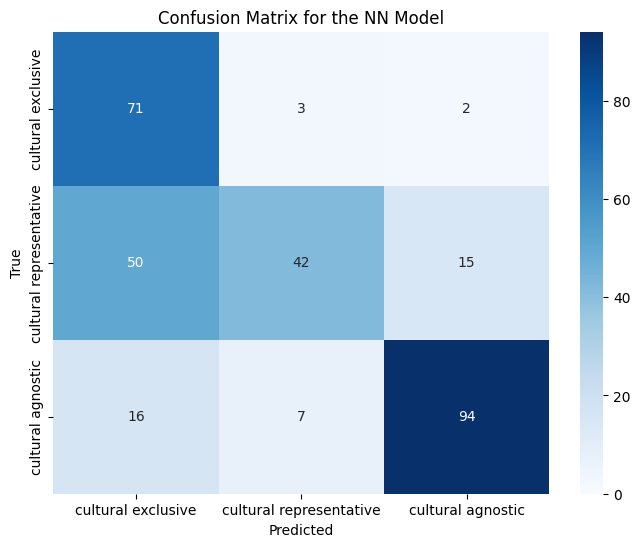

In [43]:
# Confusion Matrix
cm_NN = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for the NN Model")
plt.show()
